---
**Project**: Cable Burial Operability  
**Author**: Alejandra L. Cameselle  
**Date**: June 2025  
**Notebook**: 04 – Burial Feasibility and Operability Map

### Description  
This notebook classifies each grid cell according to burial feasibility based on bathymetry and slope constraints. The resulting map serves as a decision-support tool for cable route planning by identifying zones where burial is required and technically feasible or not feasible.

### Inputs  
- `02_grid_depth_slope.gpkg`: Grid with depth and slope data  
- Burial constraints:  
  - Burial required if depth < 1000 m  
  - Burial not feasible if slope > 7°  

### Processing  
- Apply decision rules to classify each cell into one of three clasess:  

| Depth (m)       | Slope (°)        | Burial Required | Burial Possible | Class                  |
|-----------------|------------------|------------------|------------------|------------------------|
| ≥ -1000         | ≤ 7              | Yes              | Yes              | Required & possible    |
| ≥ -1000         | > 7              | Yes              | No               | Required & not possible|
| < -1000         | Any              | No               | Not needed       | No burial needed       |

- Export result as GeoPackage  
- Plot classified grid for visual assessment

### Outputs  
- `04_grid_burial_operability.gpkg`: Grid with `burial_operability` field  
- PNG plot saved in `../outputs/plots/04_burial_operability_map.png`

### Assumptions  
- Only slope and depth are considered; additional constraints (e.g. environmental, legal) are excluded at this stage  
- Burial feasibility threshold fixed at 7° slope limit
- Depth threshold is interpreted as depth_mean ≥ -1000 due to negative bathymetry convention

### Dependencies  
- geopandas, pandas, matplotlib, seaborn, numpy
---

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import os

In [2]:
# Load the grid with depth and slope
grid = gpd.read_file("../processed_data/02_grid_depth_slope.gpkg")

In [3]:
# Define burial requirement and possibility
grid["bury_required"] = grid["depth_mean"] >= -1000  # shallow water
grid["bury_possible"] = grid["slope_mean_deg"] <= 7  # gentle slope

In [4]:
# Define burial operability class
def classify_operability(row):
    if not row["bury_required"]:
        return "No burial needed"
    elif row["bury_possible"]:
        return "Required & possible"
    else:
        return "Required & not possible"

grid["operability_class"] = grid.apply(classify_operability, axis=1)

In [5]:
# Convert to ordered categorical for plotting
burial_order = ["No burial needed", "Required & possible", "Required & not possible"]
grid["operability_class"] = pd.Categorical(grid["operability_class"],
                                           categories=burial_order,
                                           ordered=True)

In [6]:
# Export grid
os.makedirs("../processed_data", exist_ok=True)
fname = f"../processed_data/04_grid_operability.gpkg"
layer = f"04_grid_operability"
grid.to_file(fname, layer=layer, driver="GPKG")

print(f"Grid exported: {fname}")

Grid exported: ../processed_data/04_grid_operability.gpkg


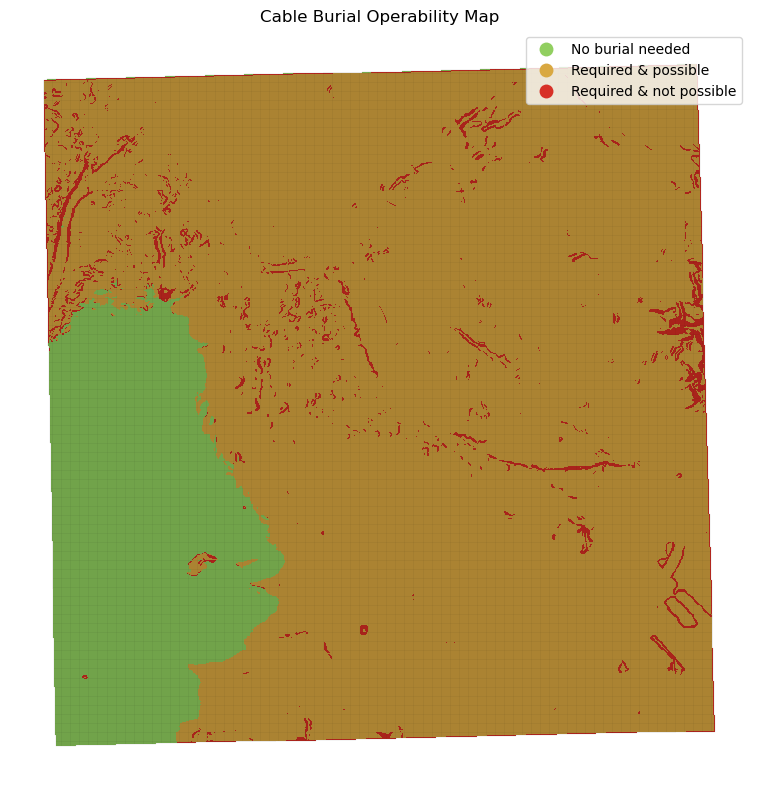

In [7]:
# Plot operability map
os.makedirs("../outputs/maps", exist_ok=True)

# Color palette: green = no burial needed, orange = feasible, red = not feasible
colors = ["#91cf60", "#d9a841", "#d73027"]
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(10, 8))
grid.plot(column="operability_class", ax=ax, cmap=cmap,
          edgecolor="black", linewidth=0.05, legend=True)
plt.title("Cable Burial Operability Map")
plt.axis("off")
plt.tight_layout()
plt.savefig("../outputs/maps/04_burial_operability_map.png", dpi=300)
plt.show()